In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from torch.utils.data import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import os
import gc

In [2]:
os.environ['TORCH_LOGS'] = "+dynamo"
os.environ['TORCHDYNAMO_VERBOSE'] = "1"

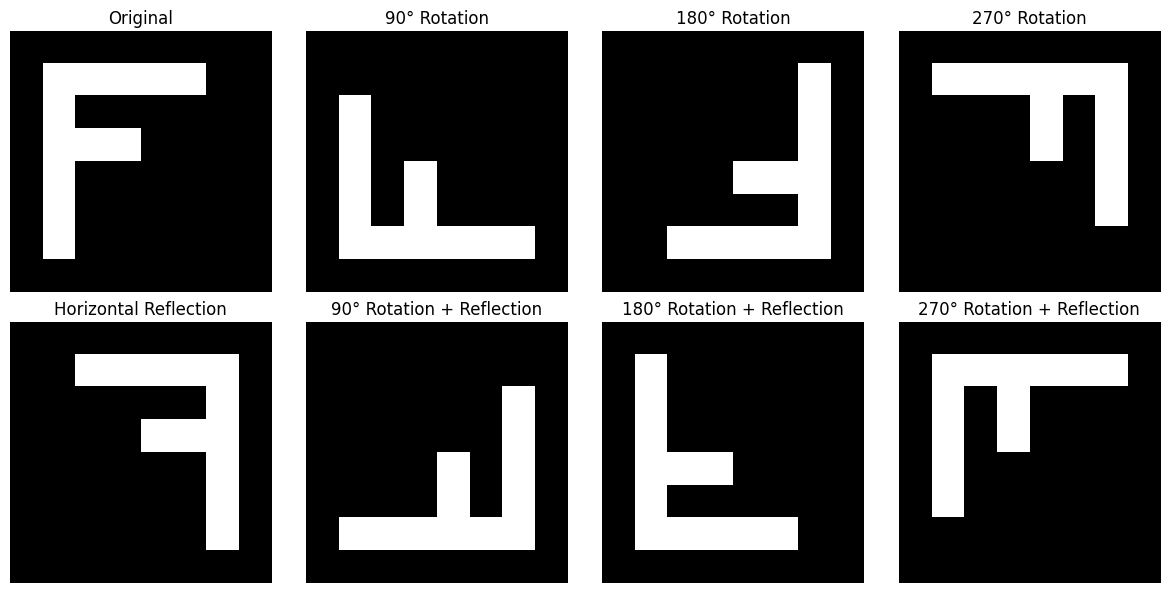

In [3]:
# Step 1: Create an image of the letter "F"
def create_letter_f():
    # Create a blank canvas
    img = torch.zeros((8, 8),dtype=torch.uint8)
    
    # Draw the letter "F"
    img[1:7, 1] = 1  # Vertical line
    img[1, 1:6] = 1  # Top horizontal line
    img[3, 1:4] = 1  # Middle horizontal line

    return img

# Step 2: Define transformations
def rotate_90(img):
    return torch.rot90(img)  # Rotate 90 degrees clockwise

def reflect_horizontal(img):
    return torch.fliplr(img)  # Flip horizontally

# Step 3: Visualize the original and transformed images
def visualize_transformations():
    # Create the original image of "F"
    original_img = create_letter_f()
    
    # Transformations
    tr=[original_img]
    for i in range(1,4):
        tr.append(rotate_90(tr[i-1]))
    for i in range(4):
        tr.append(reflect_horizontal(tr[i%4]))
    
    transformations = [
        ("Original", tr[0]),
        ("90° Rotation", tr[1]),
        ("180° Rotation", tr[2]),
        ("270° Rotation", tr[3]),
        ("Horizontal Reflection", tr[4]),
        ("90° Rotation + Reflection", tr[5]),
        ("180° Rotation + Reflection", tr[6]),
        ("270° Rotation + Reflection", tr[7]),
    ]
    
    # Plot the transformations
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for ax, (title, img) in zip(axes.flatten(), transformations):
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    return tr
# Call the visualization function
tr=visualize_transformations()

In [4]:
class D4EquivariantConv(nn.Module):
    """
    A convolutional layer that achieves equivariance to the dihedral group D4 (rotations and reflections).
    
    This layer creates 8 transformations for each kernel: 4 rotations (0°, 90°, 180°, 270°) and 4 reflections 
    of each one of these rotations. The output for each transformed kernel is concatenated along the channel dimension, 
    allowing the model to learn features equivariant to these transformations.
    
    Attributes:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int
        Size of the convolutional kernel (default is 3).
    padding : int
        Padding applied to the input (default is 1).
    stride : int
        Stride of the convolution (default is 1).
    bias : bool
        If True, adds a learnable bias to the output (default is True).
    num_transformations : int
        Number of transformations in the D4 group, set to 8.
    
    Methods:
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Applies the D4 transformations to the convolutional kernel and performs convolution on the input tensor.
    
    Transformation Details:
    -----------------------
    For each original kernel:
        1. Rotate it by 90° counterclockwise three times to create 4 rotations (0°, 90°, 180°, 270°).
        2. Reflect the original kernel horizontally and then apply the 4 rotations to the reflected kernel.
        
    This process results in 8 transformations per kernel. The transformed kernels are used for convolution,
    allowing the model to learn features that are robust to rotations and reflections.
    
    Examples:
    --------
    >>> layer = D4EquivariantConv(in_channels=1, out_channels=16)
    >>> input_tensor = torch.randn(1, 1, 32, 32)
    >>> output = layer(input_tensor)
    """
    
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int=3, padding:int=1, stride:int=1, bias:bool=True):
        super(D4EquivariantConv, self).__init__()
        # Order of Dihedral group D4
        self.num_transformations=8
        
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.padding=padding
        self.stride=stride

        self.weight = nn.Parameter(torch.zeros((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)))
        if bias:
            self.bias_weight = nn.Parameter(torch.zeros(self.out_channels))
        else:
            self.bias_weight=None

        # Kaiming uniform initialization
        nn.init.kaiming_uniform_(self.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x:torch.Tensor):
        # Create tensor to populate with all transformed kernels
        transformed_filters = torch.empty((self.num_transformations*self.out_channels,
                                           self.in_channels,
                                           self.kernel_size,
                                           self.kernel_size), device=x.device)
        # Generate all 8 transformations
        for i in range(4):
            # Pure rotation for each of the 4 rotations
            rotated_weight = torch.rot90(self.weight, i, [2, 3])
            transformed_filters[i * self.out_channels:(i + 1) * self.out_channels] = rotated_weight
            
            # Reflected versions of each rotation
            reflected_weight = torch.flip(rotated_weight, dims=[3])
            transformed_filters[(i + 4) * self.out_channels:(i + 5) * self.out_channels] = reflected_weight


        # Repeat bias for each transformed kernel if it exists
        expanded_bias = self.bias_weight.repeat(self.num_transformations) if self.bias_weight is not None else None

        # Perform convolution using the combined filters
        out = F.conv2d(x, transformed_filters, padding=self.padding, bias=expanded_bias, stride=self.stride)

        return out, transformed_filters 

test=D4EquivariantConv(1,1)

In [44]:
# Function to create the letter "F"
def create_letter_f():
    img = torch.zeros((8, 8), dtype=torch.uint8)
    img[1:7, 1] = 1  # Vertical line
    img[1, 1:6] = 1  # Top horizontal line
    img[3, 1:4] = 1  # Middle horizontal line
    return img

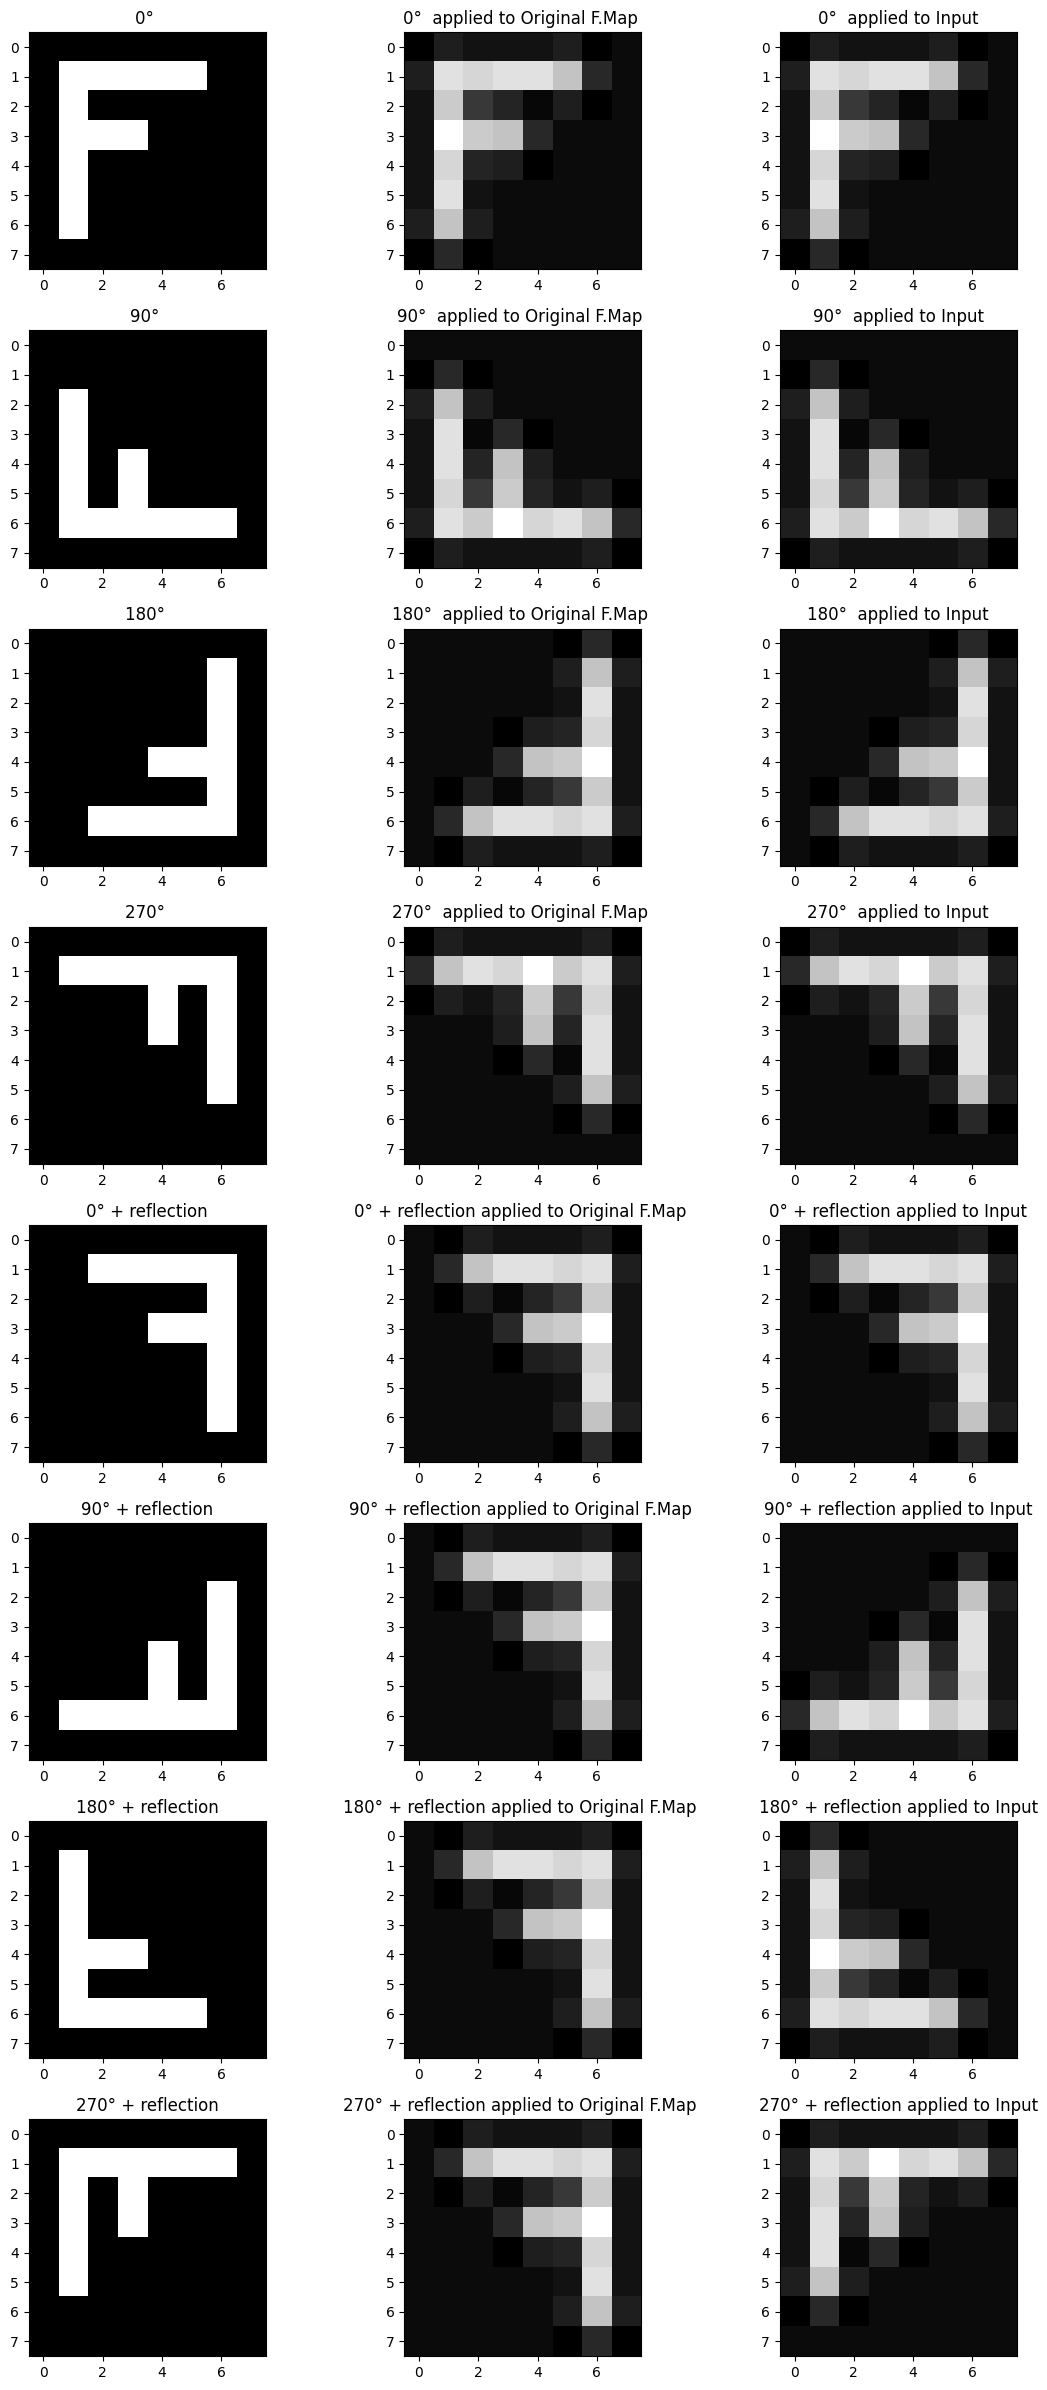

In [ ]:
# Generate the letter F
f_image = create_letter_f()
f_image = f_image.unsqueeze(0).unsqueeze(0).float()  # Add batch and channel dimensions

# Initialize the D4EquivariantConv layer
conv_layer = D4EquivariantConv(in_channels=1, out_channels=1).eval()

# Perform avg pooling over the group dimension
avg_pool = lambda x: torch.sum(x, dim=1,keepdim=True) / 8  # Avg pool over the transformations (group dimension)

# Apply the convolutional layer to the original image
original_output, _ = conv_layer(f_image)
pooled_original_output = avg_pool(original_output)

# Set up the plot grid for 8 rows and 3 columns
fig, axs = plt.subplots(8, 3, figsize=(12, 24))

# Loop over the 8 transformations (rotations and reflections)
for i in range(8):
    # Step 1: Apply transformation (rotation + reflection)
    current_transformed_img = torch.rot90(f_image, i % 4, [2, 3])  # Rotate by 0, 90, 180, or 270 degrees
    transformed_pooled_original_output=torch.rot90(pooled_original_output, i % 4, [2, 3])
    title_transformation=f'{i*90 % 360}° '
    if i >= 4:
        current_transformed_img = torch.flip(current_transformed_img, dims=[3])  # Reflect the image for i >= 4
        transformed_pooled_original_output=torch.flip(pooled_original_output, dims=[3])
        title_transformation+='+ reflection'

    # Step 2: Apply the convolutional layer to the transformed image
    output_transformed_img, _ = conv_layer(current_transformed_img)

    # Step 3: Perform average pooling over the group dimension
    pooled_current_transformed_img = avg_pool(output_transformed_img)

    # Step 4: Plot the results
    # First column: Plot the transformed image
    axs[i, 0].imshow(current_transformed_img[0, 0].cpu().numpy(), cmap='gray')
    axs[i, 0].set_title(title_transformation)

    # Second column: Plot the feature map of the transformed image
    axs[i, 1].imshow(transformed_pooled_original_output[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[i, 1].set_title(f"{title_transformation} applied to Original F.Map ")

    # Third column: Plot the pooled feature map
    axs[i, 2].imshow(pooled_current_transformed_img[0,0].cpu().detach().numpy(), cmap='gray')
    axs[i, 2].set_title(f"{title_transformation} applied to Input")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [45]:
class D4EquivariantConvTranspose(nn.Module):
    """
    A layer that performs an equivariant "deconvolution" to the dihedral group D4 by:
    1. Upsampling the input by inserting zeros between rows and columns.
    2. Applying the D4-equivariant convolution layer to the upsampled input.
    """
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 2, bias: bool = True):
        super(D4EquivariantConvTranspose, self).__init__()
        
        # Calculate padding explicitly to avoid border artifacts
        padding = (kernel_size - 1) // 2
        
        # Using an equivariant convolution layer
        self.equiv_conv = D4EquivariantConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=1,         # Stride of 1 since upsampling is done manually
            bias=bias
        )
        self.stride = stride

    def forward(self, x: torch.Tensor):
        # Step 1: Insert zeros between rows and columns to simulate ConvTranspose2d upsampling
        n, c, h, w = x.size()
        upsampled = torch.zeros(n, c, h * self.stride, w * self.stride, device=x.device)
        upsampled[:, :, ::self.stride, ::self.stride] = x

        # Step 2: Apply the D4 equivariant convolution to the upsampled input
        out, transformed_kernels = self.equiv_conv(upsampled)
        
        return out, transformed_kernels


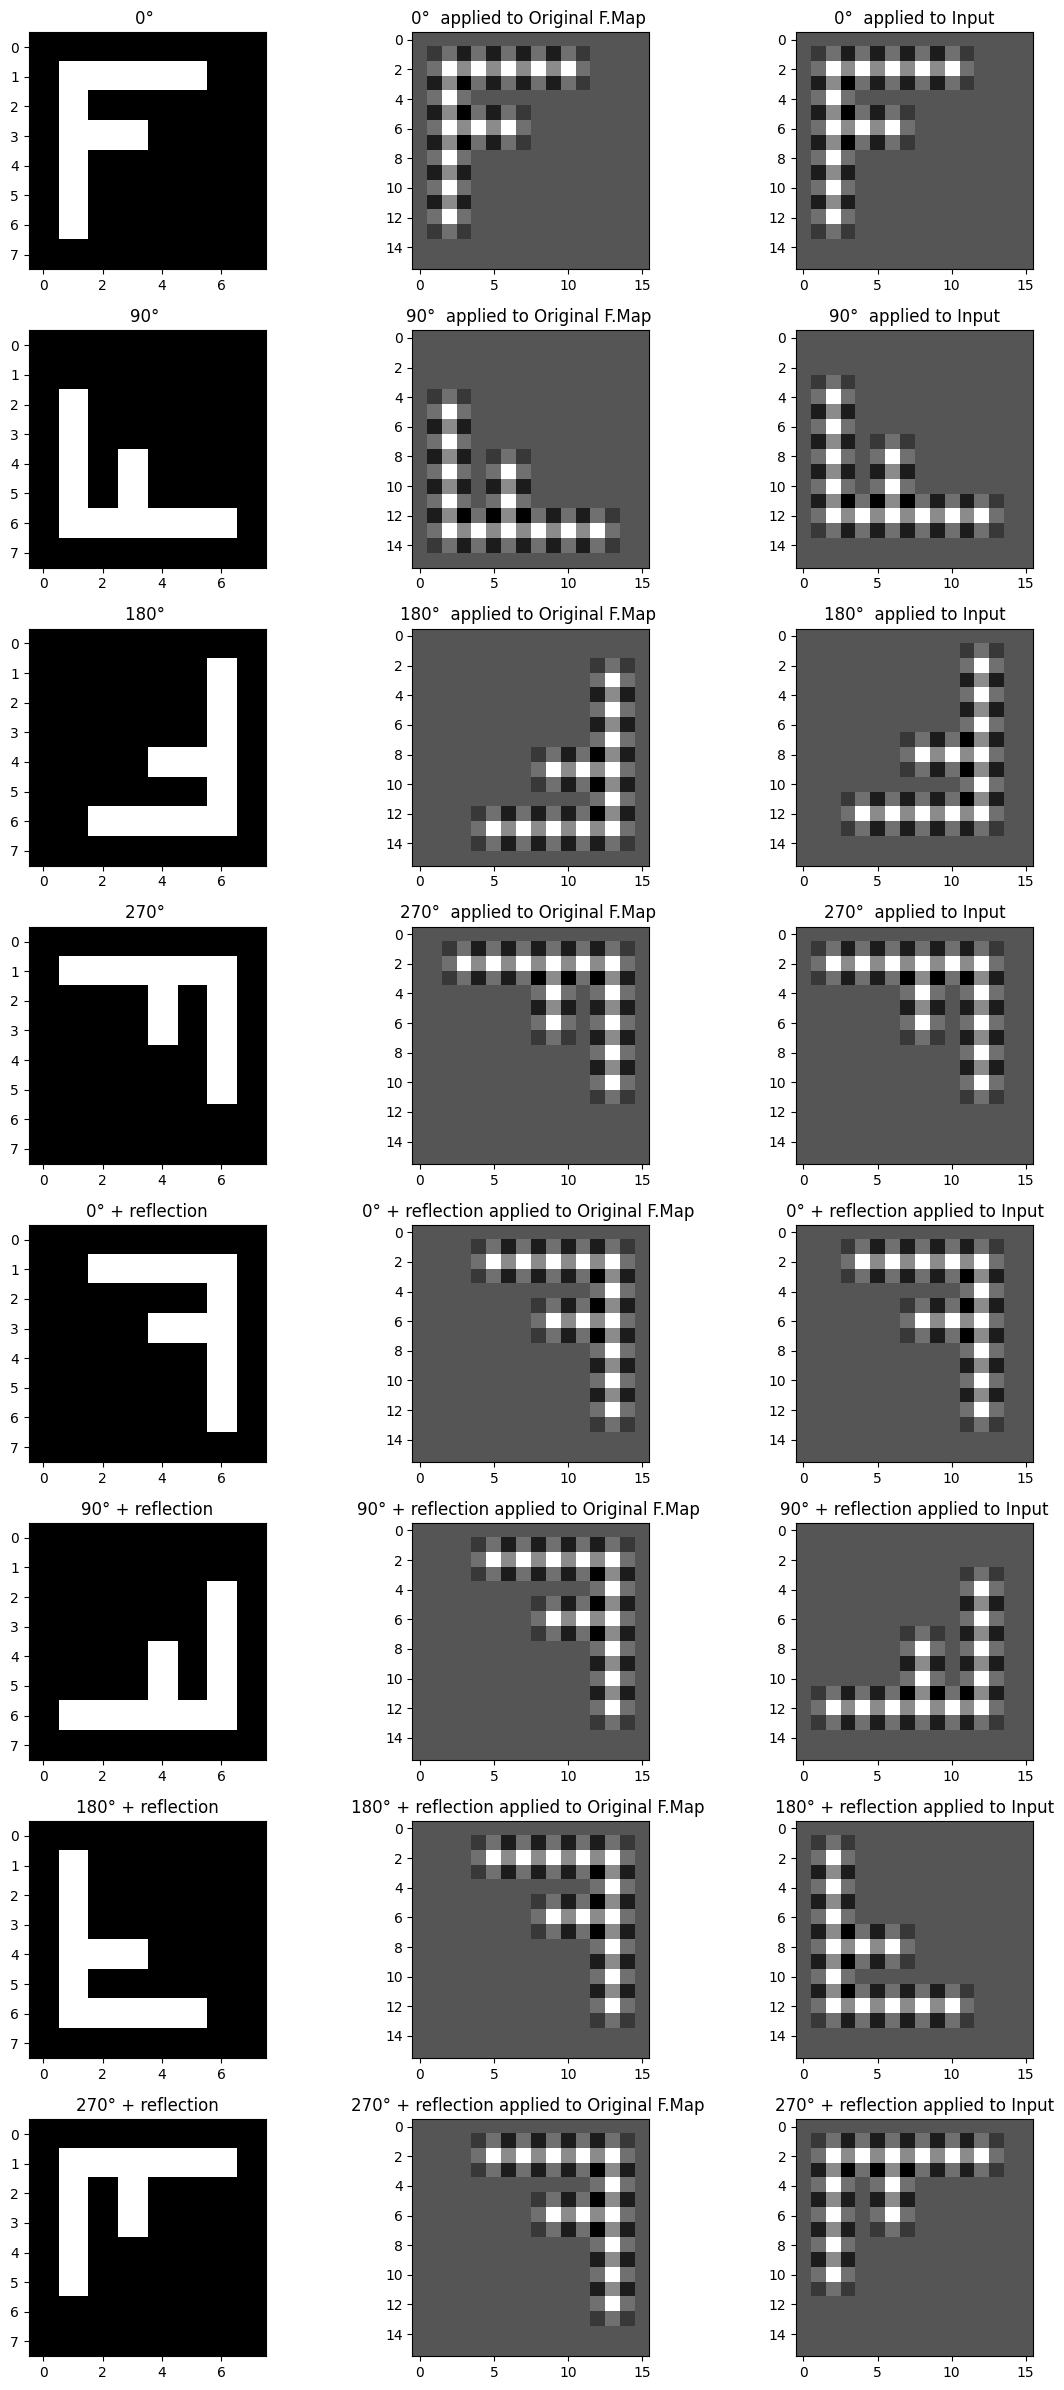

In [46]:
# Generate the letter F
f_image = create_letter_f()
f_image = f_image.unsqueeze(0).unsqueeze(0).float()  # Add batch and channel dimensions

# Initialize the D4EquivariantConv layer
conv_layer = D4EquivariantConvTranspose(in_channels=1, out_channels=1).eval()

# Perform avg pooling over the group dimension
avg_pool = lambda x: torch.sum(x, dim=1,keepdim=True) / 8  # Avg pool over the transformations (group dimension)

# Apply the convolutional layer to the original image
original_output, _ = conv_layer(f_image)
pooled_original_output = avg_pool(original_output)

# Set up the plot grid for 8 rows and 3 columns
fig, axs = plt.subplots(8, 3, figsize=(12, 24))

# Loop over the 8 transformations (rotations and reflections)
for i in range(8):
    # Step 1: Apply transformation (rotation + reflection)
    current_transformed_img = torch.rot90(f_image, i % 4, [2, 3])  # Rotate by 0, 90, 180, or 270 degrees
    transformed_pooled_original_output=torch.rot90(pooled_original_output, i % 4, [2, 3])
    title_transformation=f'{i*90 % 360}° '
    if i >= 4:
        current_transformed_img = torch.flip(current_transformed_img, dims=[3])  # Reflect the image for i >= 4
        transformed_pooled_original_output=torch.flip(pooled_original_output, dims=[3])
        title_transformation+='+ reflection'

    # Step 2: Apply the convolutional layer to the transformed image
    output_transformed_img, _ = conv_layer(current_transformed_img)

    # Step 3: Perform average pooling over the group dimension
    pooled_current_transformed_img = avg_pool(output_transformed_img)

    # Step 4: Plot the results
    # First column: Plot the transformed image
    axs[i, 0].imshow(current_transformed_img[0, 0].cpu().numpy(), cmap='gray')
    axs[i, 0].set_title(title_transformation)

    # Second column: Plot the feature map of the transformed image
    axs[i, 1].imshow(transformed_pooled_original_output[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[i, 1].set_title(f"{title_transformation} applied to Original F.Map ")

    # Third column: Plot the pooled feature map
    axs[i, 2].imshow(pooled_current_transformed_img[0,0].cpu().detach().numpy(), cmap='gray')
    axs[i, 2].set_title(f"{title_transformation} applied to Input")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
